# ДЗ_4. "Модели авторегрессии условной гетероскедантичности"

## Задание

- Выберите ряд и постройте его модель GARCH.


In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
# Временной ряд беру как и в прошлом ДЗ!

In [6]:
series = pd.read_csv("Series/international-airline-passengers.csv").dropna().values[:, 1]
print(series)

[112 118 132 129 121 135 148 148 136 119 104 118 115 126 141 135 125 149
 170 170 158 133 114 140 145 150 178 163 172 178 199 199 184 162 146 166
 171 180 193 181 183 218 230 242 209 191 172 194 196 196 236 235 229 243
 264 272 237 211 180 201 204 188 235 227 234 264 302 293 259 229 203 229
 242 233 267 269 270 315 364 347 312 274 237 278 284 277 317 313 318 374
 413 405 355 306 271 306 315 301 356 348 355 422 465 467 404 347 305 336
 340 318 362 348 363 435 491 505 404 359 310 337 360 342 406 396 420 472
 548 559 463 407 362 405 417 391 419 461 472 535 622 606 508 461 390 432]


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


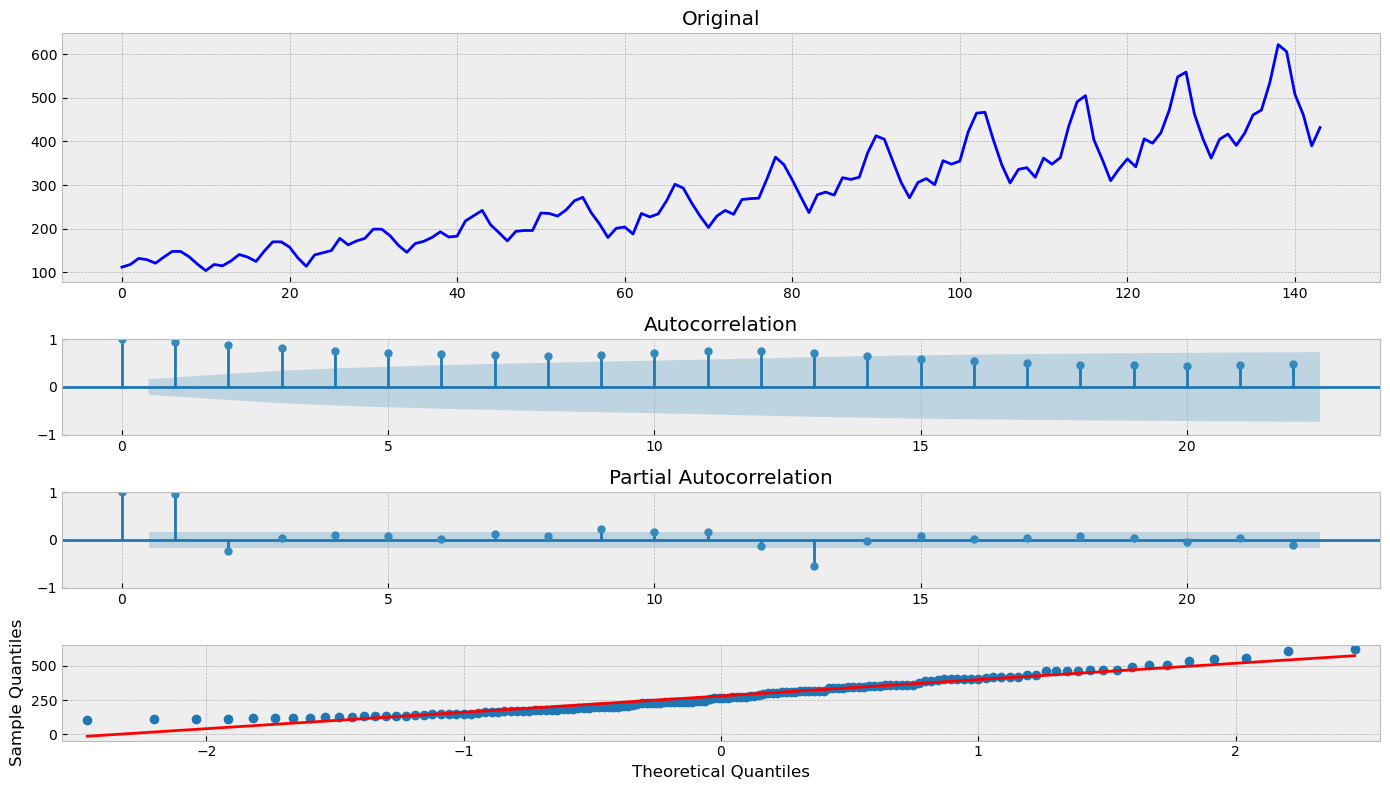

In [7]:
tsplot(series)

### GARCH

In [8]:
# pip install update arch

In [9]:
from arch import arch_model

In [10]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [11]:
series = series.astype(float)

In [12]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 2
o_ = 1
q_ = 2

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -506.899
Distribution:      Standardized Student's t   AIC:                           1029.80
Method:                  Maximum Likelihood   BIC:                           1052.80
                                              No. Observations:                  131
Date:                      Fri, Nov 10 2023   Df Residuals:                      130
Time:                              16:04:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


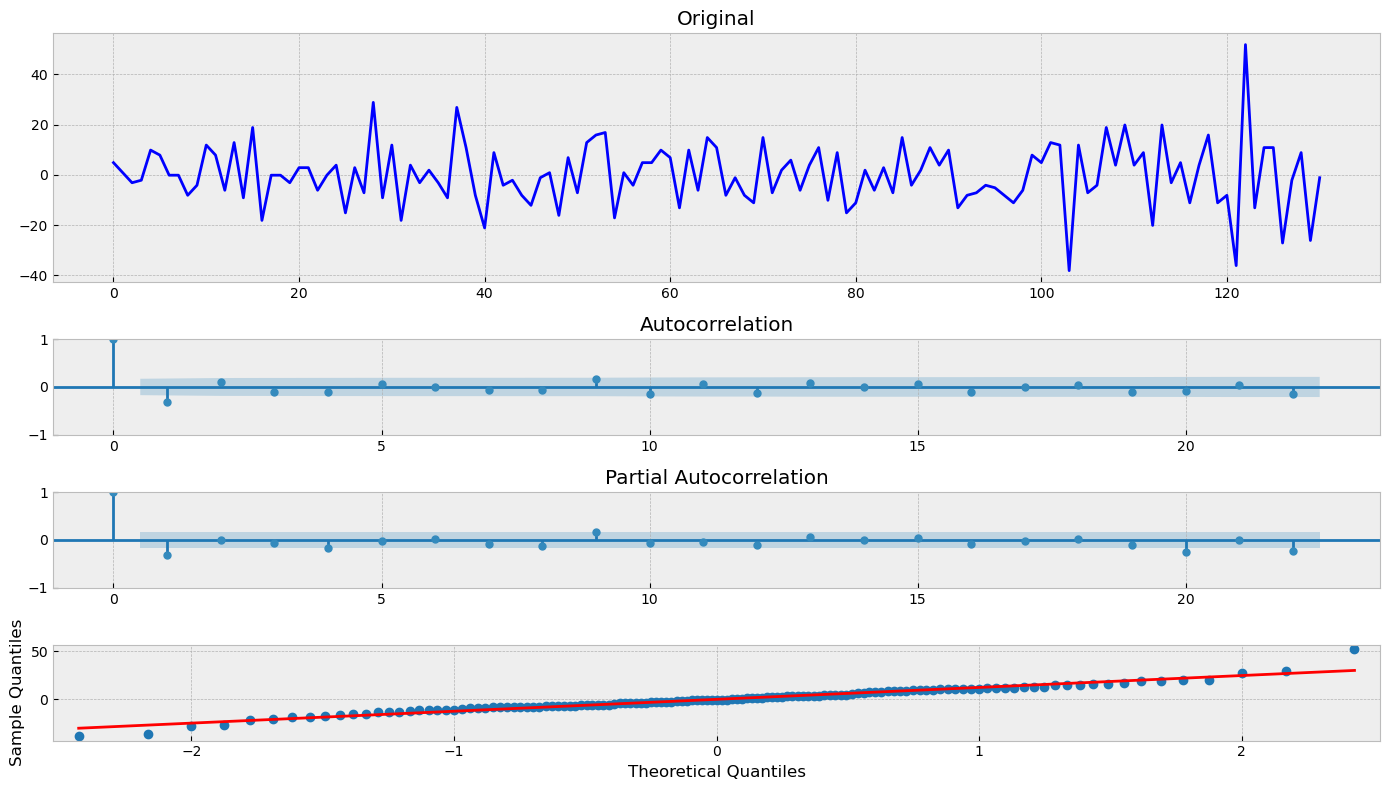

In [13]:
tsplot(res.resid)

#### Определим лучшие параметры GARCH

In [14]:
warnings.filterwarnings("ignore")

In [15]:
def _get_best_garch_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    # Иттерируем p, q, и o from 0 to 4
    for p in range(5):
        for o in range(5):
            for q in range(5):
                try:
                    # Fit GARCH model c различными комбинациями p, q, o
                    tmp_mdl = arch_model(TS, vol = 'Garch', p = p, o = o, q = q).fit()
                    # считаем AIC - fitted model
                    tmp_aic = tmp_mdl.aic
                      # Если AIC меньше чем best_aic, обновляем best_aic, best_order, and best_mdl
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, o, q)
                        best_mdl = tmp_mdl
                except: 
                    continue
                    
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                
    return best_aic, best_order, best_mdl

In [16]:
# aic, order, mdl = _get_best_garch_model(new_series)

In [17]:
aic, order, mdl = _get_best_garch_model(series)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 520.936046845992
Iteration:      2,   Func. Count:     10,   Neg. LLF: 518.3864570047158
Iteration:      3,   Func. Count:     14,   Neg. LLF: 517.7507304400177
Iteration:      4,   Func. Count:     18,   Neg. LLF: 517.3978463122103
Iteration:      5,   Func. Count:     22,   Neg. LLF: 516.9365264095445
Iteration:      6,   Func. Count:     26,   Neg. LLF: 516.4498716086489
Iteration:      7,   Func. Count:     30,   Neg. LLF: 515.9948475182654
Iteration:      8,   Func. Count:     34,   Neg. LLF: 514.2354635854027
Iteration:      9,   Func. Count:     38,   Neg. LLF: 512.1357737219439
Iteration:     10,   Func. Count:     42,   Neg. LLF: 510.78305991069385
Iteration:     11,   Func. Count:     46,   Neg. LLF: 510.5171675218624
Iteration:     12,   Func. Count:     50,   Neg. LLF: 510.316812713606
Iteration:     13,   Func. Count:     54,   Neg. LLF: 510.31003426963406
Iteration:     14,   Func. Count:     58,   Neg. LLF: 510.309305

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


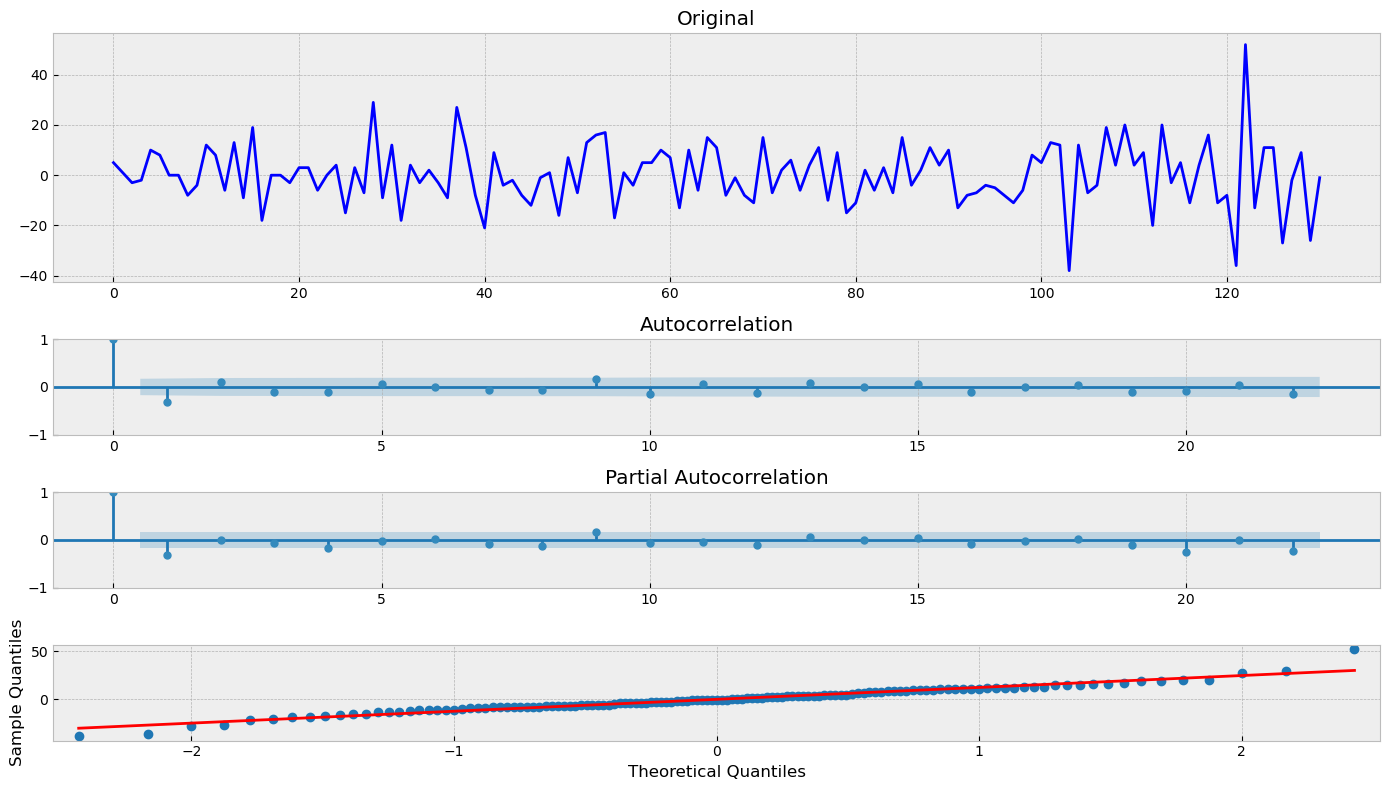

In [18]:
tsplot(mdl.resid)

> По графикам видим что распределение практически нормальное, вытащить из ряда больше практически нечего.

In [19]:
res_model = arch_model(series, p = order[0], o = order[1], q = order[2], dist='StudentsT')
res_model_fit = res_model.fit(update_freq=5)
print(res_model_fit.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 508.1988641236451
Iteration:     10,   Func. Count:     65,   Neg. LLF: 507.56357272180514
Iteration:     15,   Func. Count:     96,   Neg. LLF: 507.44827063435787
Iteration:     20,   Func. Count:    127,   Neg. LLF: 507.42188168084886
Iteration:     25,   Func. Count:    158,   Neg. LLF: 507.3865679406514
Optimization terminated successfully    (Exit mode 0)
            Current function value: 507.38656686473047
            Iterations: 27
            Function evaluations: 169
            Gradient evaluations: 27
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -507.387
Distribution:      Standardized Student's t   AIC:                           1024.77
M

In [20]:
# forecasts = res_model_fit.forecast(horizon=10)

In [21]:
# predictions = forecasts.mean

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


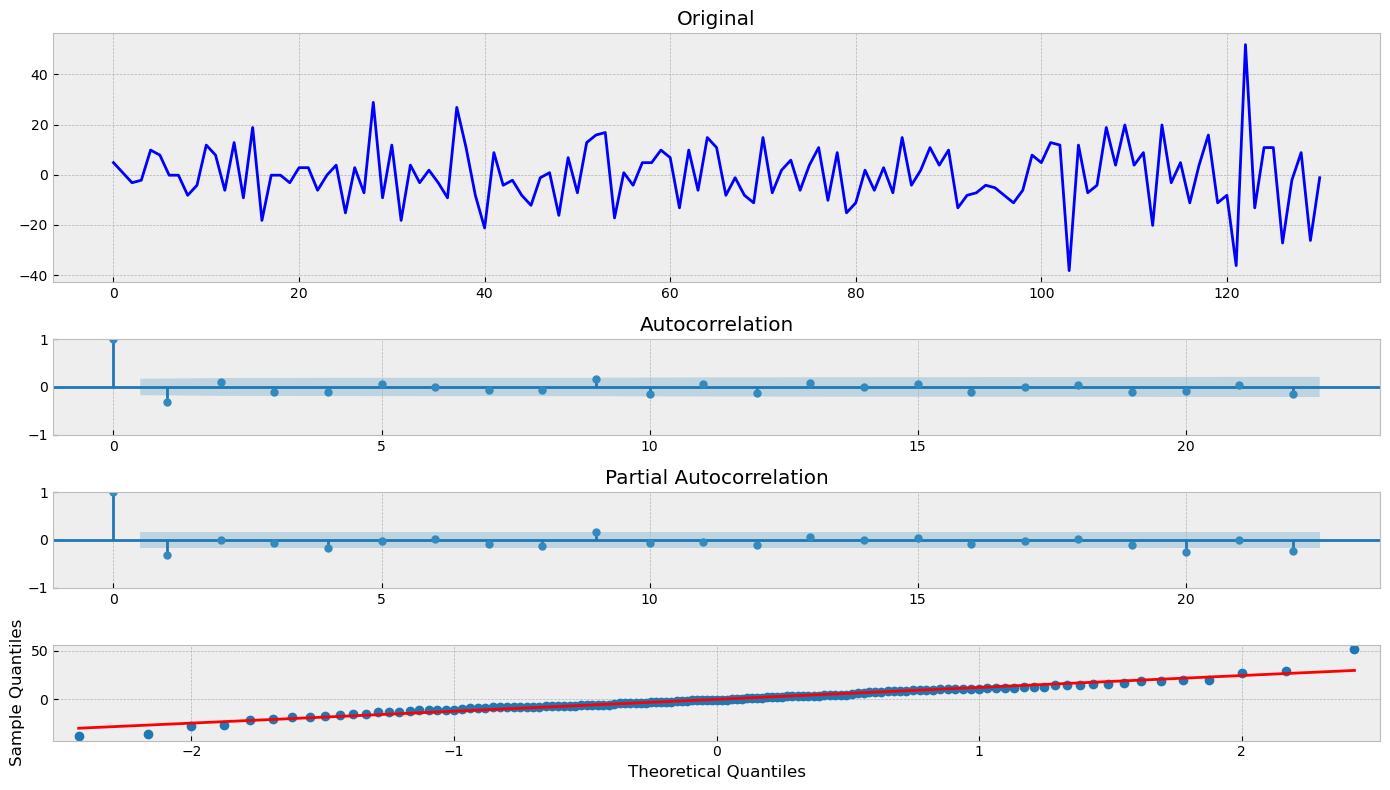

In [22]:
tsplot(res_model_fit.resid)